In [1]:
import numpy as np
from numba import jit

In [2]:
@jit(nopython=True) 
def mttcrp(coo_tensor, vals, shape, mode, a, b):
    """
        Calculate matricized-tensor times Khatri-Rao product. 
    """
    temp = np.zeros(shape=(shape[mode], a.shape[1]))
    
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
        
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        temp[coord[mode], :] += a[coord[mode_a], :] * b[coord[mode_b], :] * vals[item] 
    
    return temp

In [3]:
@jit(nopython=True)
def gaussian_loss(x_vals, m_vals):
    return (x_vals - m_vals)**2

@jit(nopython=True)
def gaussian_loss_grad(x_vals, m_vals):
    return -2 * (x_vals - m_vals)

In [4]:
@jit(nopython=True)
def bernoulli_logit_loss(x_vals, m_vals):
    return np.log(1 + np.exp(m_vals)) - (x_vals * m_vals)

@jit(nopython=True)
def bernoulli_logit_loss_grad(x_vals, m_vals):
    exp_vals = np.exp(m_vals)
    return (exp_vals / (1 + exp_vals)) - x_vals

In [6]:
@jit(nopython=True)
def get_elem_deriv_tensor(coo_tensor, vals, kruskal_vals, loss_function_grad):
    """
        Calculate the elementwise derivative tensor Y.
    """
    
    deriv_tensor_vals = loss_function_grad(vals, kruskal_vals) / vals.size
    return deriv_tensor_vals    

In [7]:
@jit(nopython=True)
def factors_to_tensor(coo_tensor, vals, a, b, c):
    """
        Calculate Kruskal tensor values with
        the same coordinates as initial tensor has.
    """
    
    krus_vals = np.zeros_like(vals)
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        krus_vals[item] = np.sum(
            a[coord[0], :] * b[coord[1], :] * c[coord[2], :]
        )
    return krus_vals    

In [118]:
@jit(nopython=True)
def gcp_fg(coo_tensor, vals, shape, a, b, c, l2, loss_function, loss_function_grad):
    """
        GCP loss function and gradient calculation.
        All the tensors have the same coordinate set: coo_tensor.
    """
    
    # Construct sparse kruskal tensor
    kruskal_vals = factors_to_tensor(coo_tensor, vals, a, b, c)
    
    # Calculate mean loss on known entries
    loss_array = loss_function(vals, kruskal_vals)
    loss = np.mean(loss_array)
    
    # Compute the elementwise derivative tensor
    deriv_tensor_vals = get_elem_deriv_tensor(
        coo_tensor, vals, kruskal_vals, loss_function_grad
    )
    
    # Calculate gradients w.r.t. a, b, c factor matrices
    g_a = mttcrp(coo_tensor, deriv_tensor_vals, shape, 0, b, c)
    g_b = mttcrp(coo_tensor, deriv_tensor_vals, shape, 1, a, c)
    g_c = mttcrp(coo_tensor, deriv_tensor_vals, shape, 2, a, b)
    
    # Add L2 regularization
    if l2 != 0:
        g_a += l2 * a
        g_b += l2 * b
        g_c += l2 * c
    
    return loss, g_a, g_b, g_c

In [119]:
@jit(nopython=True)
def gcp_gd(coo_tensor,
           vals,
           shape,
           loss_function,
           loss_function_grad,
           rank=5,
           lr=0.1,
           l2=0,
           max_iter=20,
           tol=1e-8,
           seed=13,
           show_iter=False,
           it_over=True):
    """
        Factorize initial sparse tensor by generalized CP decomposition.
    """
    
    random_state = np.random.seed(seed)
    a = np.random.normal(0.0, 0.1, size=(shape[0], rank))
    b = np.random.normal(0.0, 0.1, size=(shape[1], rank))
    c = np.random.normal(0.0, 0.1, size=(shape[2], rank))
    
    err_arr = np.empty((max_iter, 1))
    it = 0
    err1 = 1.0
    err2 = 0.0
    while np.abs(err1 - err2) > tol:
        
        # Get loss and gradients
        error, g_a, g_b, g_c = gcp_fg(
            coo_tensor, vals, shape, a, b, c,
            l2, loss_function, loss_function_grad,
        )
        
        # Update factor matrices
        a = a - (lr * g_a)
        b = b - (lr * g_b)
        c = c - (lr * g_c)
        
        it += 1
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        if show_iter:
            print("Iter: ", it, "; Error: ", error)
            
        if it == max_iter:
            if it_over:
                print("iterations over")
            break
    
    return a, b, c, err_arr, it

In [23]:
import matplotlib.pyplot as plt

from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

In [120]:
%%time
shape = (100, 100, 100)
coo, vals = gen_coo_tensor(init_shape, density=0.02)
assert check_coo_tensor(coo)!= "Bad"

CPU times: user 81 µs, sys: 2 µs, total: 83 µs
Wall time: 86.3 µs


In [121]:
max_iter = 20
rank = 3

In [129]:
%%time

a, b, c, err, it = gcp_gd(
    coo, vals, shape,
    bernoulli_logit_loss,
    bernoulli_logit_loss_grad,
    rank=rank,
    lr=0.1,
    l2=0,
    max_iter=max_iter,
    tol=1e-8,
    seed=13,
    show_iter=False,
    it_over=True,
)

iterations over
CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.55 ms


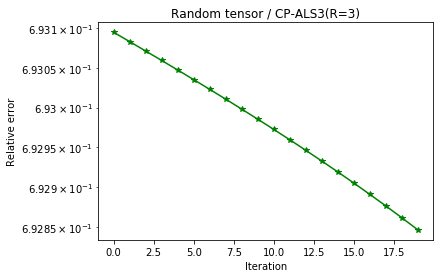

In [130]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor / CP-ALS3(R={rank})")
#plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'g-*')

In [101]:
import CP_ALS3.CP_ALS3 as cp

In [114]:
%%time
max_iter = 20
rank = 3
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)

iterations over
CPU times: user 4.07 ms, sys: 1 µs, total: 4.07 ms
Wall time: 4.08 ms


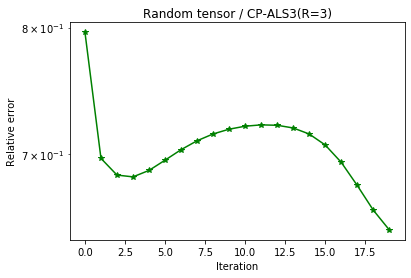

In [115]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor / CP-ALS3(R={rank})")
#plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'g-*')